In [1]:
import cv2
from sklearn import svm
import os
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn import svm
from skimage import exposure
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score


In [2]:
video_path = 'sequence/'
v_image = []
for root, dirs, files in os.walk(video_path):
    files.sort()
    for name in files:
        v_image.append(os.path.join(video_path, name))

video_sample = []
for files in v_image:
    img = cv2.imread(files)
    video_sample.append(img)

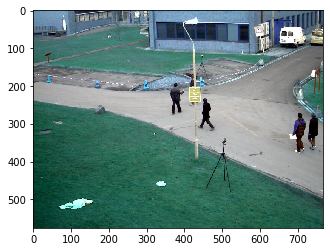

In [3]:
frame = video_sample[20]
frame_2 = video_sample[20]
plt.imshow(frame)

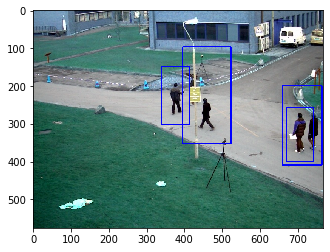

In [4]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
rects, score = hog.detectMultiScale(frame, winStride=(4,4), padding=(8,8),scale=1.03)
for (x,y,w,h) in rects:
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 2)
plt.imshow(frame)

In [5]:
print('score is : ', score)
print('rects is : ', rects)

score is :  [[1.97062753]
 [3.12291522]
 [1.17501449]
 [0.68316149]]
rects is :  [[339 149  76 152]
 [671 256  72 143]
 [660 200 105 209]
 [396  97 128 255]]


In [8]:
OPENCV_OBJECT_TRACKERS = {
    "csrt": cv2.TrackerCSRT_create,
    "kcf": cv2.TrackerKCF_create,
}

In [9]:
# Pedestrian detection area selected
BORDER = [[142, 171], [142, 339], [296, 339], [296, 171]]

def calculate(bound, mask):
    x, y, w, h = bound
    area = mask[y:y + h, x:x + w]
    pos = area > 0 + 0
    score = np.sum(pos) / (w * h)
    return score

def nms_cnts(cnts, mask, min_area):
    bounds = [cv2.boundingRect(c) for c in cnts if cv2.contourArea(c) > min_area]
    if len(bounds) == 0:
        return []
    scores = [calculate(b, mask) for b in bounds]
    bounds = np.array(bounds)
    scores = np.expand_dims(np.array(scores), axis=-1)
    nms_threshold = 0.3

    dets = np.hstack([bounds, scores])
    y1 = dets[:, 1]
    x1 = dets[:, 0]
    y2 = y1 + dets[:, 3]
    x2 = x1 + dets[:, 2]

    scores = dets[:, 4]  # bbox打分
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    # Score in descending order, index taking
    order = scores.argsort()[::-1]
    # keep reserved for the final frame
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        # Calculation window i and all other windows in the area of the overlapped portion
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        # iou
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        # inds smaller than the threshold value for all the windows with the window i iou value index, the other windows are absorbed window i
        inds = np.where(ovr <= nms_threshold)[0]
        # order to retain only those inside the window and the overlapping window area i is less than the threshold, since the order ovr length less than the length 1 (not included i), so inds + 1 to the corresponding window of reservations
        order = order[inds + 1]
    return bounds[keep]

In [ ]:
# Video file path and OpenCV Object tracker
video_path = 'sequence/'
v_image = []
for root, dirs, files in os.walk(video_path):
    files.sort()
    for name in files:
        v_image.append(os.path.join(video_path, name))

video_sample = []
for files in v_image:
    img = cv2.imread(files)
    video_sample.append(img)

moving_people = []
video_processed = []
initial_frame = 2
video_len = len(video_sample) - initial_frame
track = []
# After the row number of the selected area
peoples = []
# detection_nums times
detection_nums = -1 
for i in range(video_len):
    img_0 = video_sample[i]
    img_1 = video_sample[i+initial_frame]
    gray_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2GRAY)
    gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_diff = cv2.absdiff(gray_1, gray_0)
    peoples.append(0)
    _, mask = cv2.threshold(gray_diff, 40, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 3)
    es = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 4))
    # mask pre_dispose
    mask = cv2.dilate(mask, es, iterations=2)  
    mask = cv2.erode(mask, es, iterations=2)  
    _, cnts, _ = cv2.findContours(
        mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 300
    bounds = nms_cnts(cnts, mask, min_area)
    # trackers_region = cv2.MultiTracker_create()
    # trackers_region.add(track, img. box)
    object_tracker = "kcf"
    cv2.polylines(img_1, [np.array(BORDER)], True, (255, 0, 0), 1, cv2.LINE_AA)
    # for b in bounds:
    #     box = tuple(b)
    #     tracker = OPENCV_OBJECT_TRACKERS[object_tracker]()
    #     trackers.add(tracker, img_0, box)

    for b in bounds:
        box = tuple(b)
        #Back to the center point of the selected rectangle
        (x, y, w, h) = box
        center_x = int(x + w / 2.0)
        center_y = int(y + h / 2.0)

        #Draw tracking frame
        cv2.rectangle(img_1, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 2)
        #Drawing the centroid of the rectangular frame
        cv2.circle(img_1, (center_x, center_y), 2, (0, 0, 255), 2)
        #The number is calculated out of the selected area
        # a = BORDER[1][0]
        if center_x >= BORDER[1][0] and center_x <= BORDER[2][0]:
            if center_y >= BORDER[1][1] - 1 and center_y <= BORDER[0][1] + 1:
                peoples[i] += 1
    moving_people.append(len(bounds))
for i in range(video_len):
    cv2.putText(video_sample[i], "Num of moving People: " + str(moving_people[i]), (30,40), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,255,255), 1)
    cv2.putText(video_sample[i], "Num of People In Border: " + str(peoples[i]), (30,90), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,255,255), 1)
    cv2.imshow('Sample', video_sample[i])
    cv2.waitKey(50)
cv2.destroyAllWindows()